# Эмулятор классического рынка

Ноутбук для визуализации иследований классического рынка.

Версия 1.2

Полное описание тут: https://github.com/rosolimo212/econom_models

In [26]:
import random
import numpy as np
import pandas as pd

#настройки, с которыми лучше
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

import sys
# основной код лежит тут
import smith as smith

import datetime

# настройки графиков
from pylab import rcParams
rcParams['figure.figsize'] = 14, 12

In [3]:
# выбираем режим, генерация новой модели или загрузка уже сформированной
mode='read'
# mode='generate'

# если выбран вариант чтения, то
# файл с заводами
fact_file='data/fact_2020-01-03 22:55:26.724423.csv'
# файл с жителями
cit_file='data/cit_2020-01-03 22:55:26.753934.csv'

# если генерации, то
# число жителей
N=2000
# N=3

# число заводов
k=50
# k=3

# число раундов в модели
R=30
# R=2

In [4]:
# новый эксперимент
if mode=='generate':
    # генерация жителей
    cit_lst=[]
    for i in range(N):
        cit=smith.citizen(id=i)
        cit_lst.append(cit)

    # генерация заводов
    fact_lst=[]
    for i in range(k):
        fact=smith.factory(id=i)
        fact_lst.append(fact)

    # старт модели
    cit_df=pd.DataFrame()
    fact_df=pd.DataFrame()
    cit_df, fact_df=smith.model(cit_lst, fact_lst, R)

    # дополнительные поля для удобной работы
    lag=fact_df.sort_values(by='period').groupby(['id']).shift(1)
    fact_df['lag_price']=lag['price']
    fact_df['lag_qv']=lag['max_quality']
    fact_df['lag_pur']=lag['pur']
    fact_df['lag_capital']=lag['capital']

    fact_df['diff_price']=fact_df['price']-fact_df['lag_price']
    fact_df['diff_qv']=fact_df['max_quality']-fact_df['lag_qv']
    fact_df['diff_pur']=fact_df['pur']-fact_df['lag_pur']
    fact_df['diff_capital']=fact_df['capital']-fact_df['lag_capital']

    # запись результатов в файл
    fact_df.to_csv('data/fact_'+str(datetime.datetime.now())+'.csv', index=False)
    cit_df.to_csv('data/cit_'+str(datetime.datetime.now())+'.csv', index=False )
    
# читаем уже проведённый эксперимент
else:
    if mode=='read':  
        fact_df=pd.read_csv(fact_file)
        cit_df=pd.read_csv(cit_file)

In [5]:
len(cit_df)

60000

In [7]:
cit_df.sample(3)

,id,quality,price,citizen_id,money,period
29413,11,44.0,9.26,1413,13.77,14
44658,11,49.0,5.53,658,73.62,22
36035,11,45.0,11.57,35,31.02,18


In [9]:
fact_df[fact_df['period']==29].sort_values(by='capital', ascending=False).sample(3)

,id,max_quality,cost,capital,pur,price,period,lag_price,lag_qv,lag_pur,lag_capital,diff_price,diff_qv,diff_pur,diff_capital
1493,43,27.0,60.72,21.94,0,61.72,29,7.36,6.0,0.0,36.66,54.36,21.0,0.0,-14.72
1488,38,6.0,55.77,13.23,0,56.77,29,13.47,54.0,1706.0,33716.52,43.30,-48.0,-1706.0,-33703.29
1464,14,10.0,21.76,1.82,0,22.76,29,96.79,26.0,0.0,1.30,-74.03,-16.0,0.0,0.52


In [11]:
# датафрейм только с теми заводами, у которых были продажи
pur=fact_df[fact_df['pur']>0].sort_values(by='pur')

pur_fact=fact_df[fact_df['pur']>0]['id'].drop_duplicates()
fact_df['pur_group']=np.where(fact_df['id'].isin(pur_fact)==True,1,0)

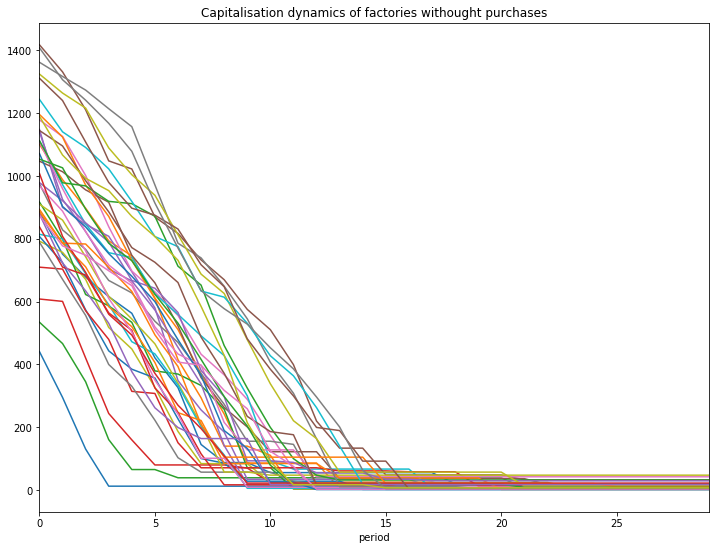

In [12]:
# картина умирания неуспеешных заводов
fact_df[(fact_df['pur_group']==0)].pivot_table(index='period', columns='id', values='capital').plot(legend=False, 
                                 figsize=(12,9), 
                                 title='Capitalisation dynamics of factories withought purchases'
                                                                          )

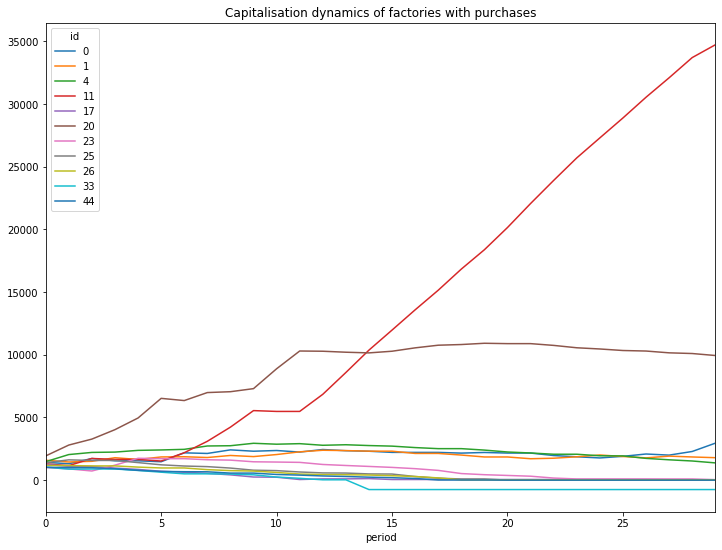

In [13]:
# смотрим на остальных
fact_df[(fact_df['pur_group']==1)].pivot_table(index='period', columns='id', values='capital').plot(legend=True, 
                                 figsize=(12,9), 
                                 title='Capitalisation dynamics of factories with purchases'
                                                                          )

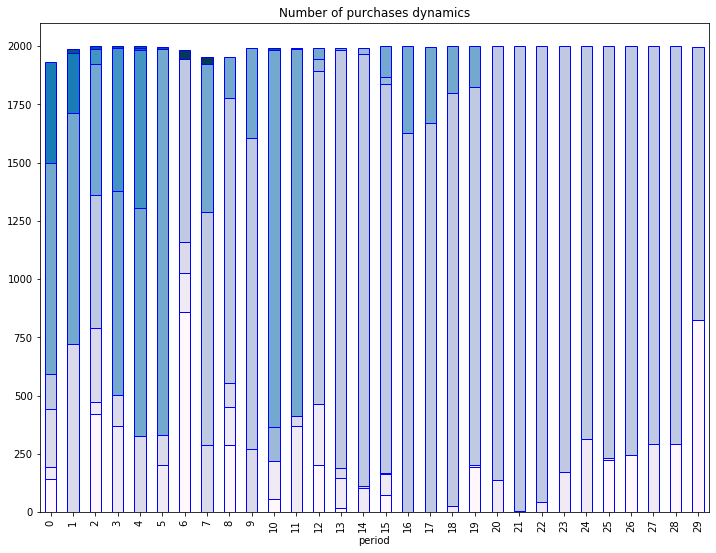

In [19]:
# структура продаж
pur.pivot_table(index='period', columns='id', values='pur').fillna(0).plot(legend=False, 
                                                                           figsize=(12,9), kind='bar',
                                                                           stacked=True, colormap='PuBu',
                                                                           edgecolor='blue',
                                                                           title='Number of purchases dynamics'
                                                                          )

In [20]:
fact_df[fact_df['id']==11][['period', 'price', 'max_quality', 'pur']].sample(3)

,period,price,max_quality,pur
411,8,23.24,42.0,1221
511,10,30.69,38.0,0
361,7,27.02,34.0,999


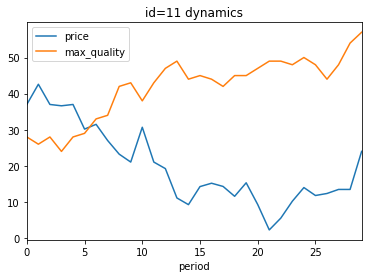

In [21]:
fact_df[fact_df['id']==11][['period', 'price', 'max_quality']].set_index('period').plot(title='id=11 dynamics')

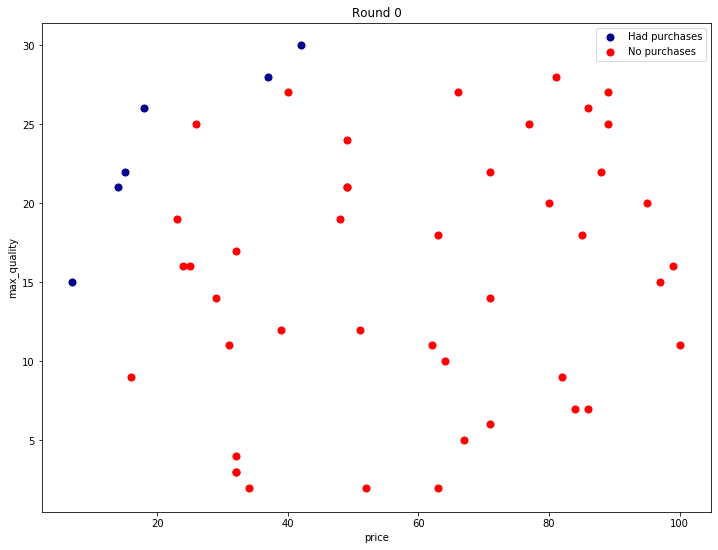

In [22]:
# визуализацимя пространства цена-качество
f0=fact_df[fact_df['period']==0].sort_values(by='price')
f0['pur_group']=np.where(f0['pur']>0,1, 0)
f0g1=f0[f0['pur']>0]
f0g2=f0[f0['pur']==0]

ax = f0g1.plot.scatter(x='price', y='max_quality', color='DarkBlue', label='Had purchases', s=50)
f0g2.plot.scatter(x='price', y='max_quality', color='Red', label='No purchases', s=50,
                  ax=ax, figsize=(12,9), title='Round 0')

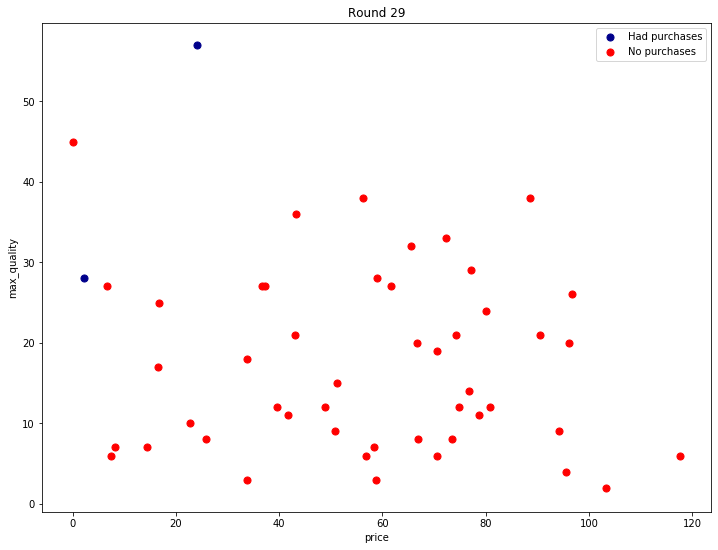

In [23]:
f0=fact_df[fact_df['period']==29].sort_values(by='price')
f0['pur_group']=np.where(f0['pur']>0,1, 0)
f0g1=f0[f0['pur']>0]
f0g2=f0[f0['pur']==0]

ax = f0g1.plot.scatter(x='price', y='max_quality', color='DarkBlue', label='Had purchases', s=50)
f0g2.plot.scatter(x='price', y='max_quality', color='Red', label='No purchases', s=50,
                  ax=ax, figsize=(12,9), title='Round 29')

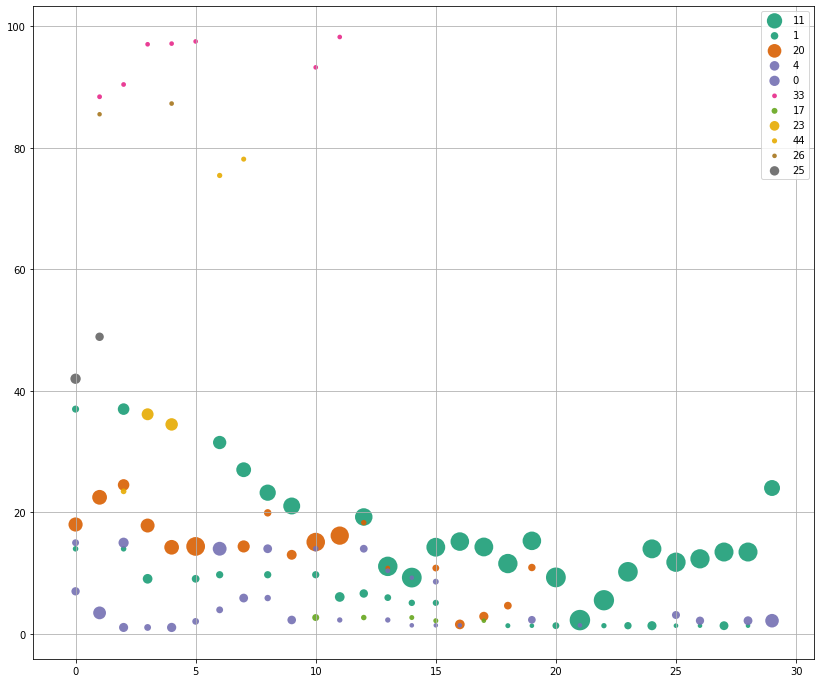

In [27]:
# каковы были продажи в динамике
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
colormap = cm.Dark2
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(pur['id'].drop_duplicates()))]


id_lst=pur['id'].value_counts().index

fig, ax = plt.subplots()
i=0
for id in id_lst:
    buf=pur[pur['id']==id]
    x=buf['period']
    y=buf['price']
    scale=20+buf['pur']/5
    color=colorlist[i]
    ax.scatter(x, y, c=color, s=scale, label=str(id), alpha=0.9, edgecolors='none')
    i=i+1
    
ax.legend()
ax.grid(True)

plt.show()

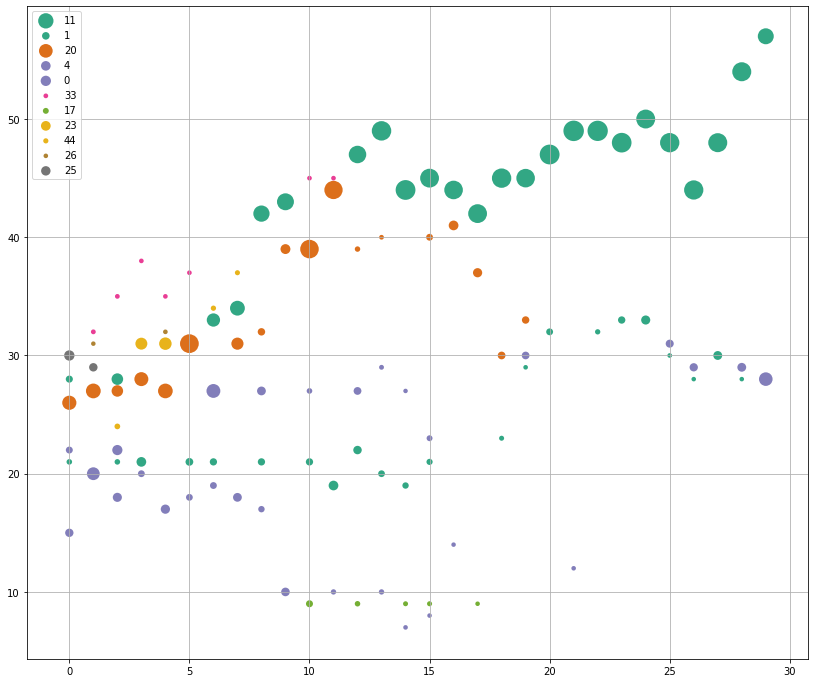

In [28]:
import matplotlib.pyplot as plt
colormap = cm.Dark2
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(pur['id'].drop_duplicates()))]


id_lst=pur['id'].value_counts().index

fig, ax = plt.subplots()
i=0
for id in id_lst:
    buf=pur[pur['id']==id]
    x=buf['period']
    y=buf['max_quality']
    scale=20+buf['pur']/5
    color=colorlist[i]
    ax.scatter(x, y, c=color, s=scale, label=str(id), alpha=0.9, edgecolors='none')
    i=i+1
    
ax.legend()
ax.grid(True)

plt.show()

In [30]:
fact_df.sample(3)

,id,max_quality,cost,capital,pur,price,period,lag_price,lag_qv,lag_pur,lag_capital,diff_price,diff_qv,diff_pur,diff_capital,pur_group
1365,15,8.0,72.39,3.39,0,73.39,27,56.25,38.0,0.0,1.32,17.14,-30.0,0.0,2.07,0
97,47,24.0,82.10,777.31,0,83.10,1,32.00,3.0,0.0,1417.76,51.10,21.0,0.0,-640.45,0
1250,0,31.0,2.10,1900.90,223,3.10,25,43.27,36.0,0.0,16.86,-40.17,-5.0,223.0,1884.04,1


In [36]:
# приросты к прошлым периодам
lag=fact_df.sort_values(by='period').groupby(['id']).shift(1)
fact_df['lag_price']=lag['price']
fact_df['lag_qv']=lag['max_quality']
fact_df['lag_pur']=lag['pur']
fact_df['lag_capital']=lag['capital']

fact_df['diff_price']=fact_df['price']-fact_df['lag_price']
fact_df['diff_qv']=fact_df['max_quality']-fact_df['lag_qv']
fact_df['diff_pur']=fact_df['pur']-fact_df['lag_pur']
fact_df['diff_capital']=fact_df['capital']-fact_df['lag_capital']

fact_df['sign_diff_price']=np.sign(fact_df['diff_price'])
fact_df['sign_diff_qv']=np.sign(fact_df['diff_qv'])
fact_df['sign_diff_pur']=np.sign(fact_df['diff_pur'])
fact_df['sign_diff_capital']=np.sign(fact_df['diff_capital'])

fact_df['experiment']=fact_df['id'].astype('str')+'_'+fact_df['period'].astype('str')

In [32]:
price_fact=fact_df[fact_df['sign_diff_price']==-1].groupby(['sign_diff_price', 'sign_diff_pur']).agg({'experiment': lambda x: x.nunique()}).reset_index()

price_fact['share']=price_fact['experiment']/np.sum(price_fact['experiment'])

In [33]:
price_fact

,sign_diff_price,sign_diff_pur,experiment,share
0,-1.0,-1.0,16,0.051613
1,-1.0,0.0,251,0.809677
2,-1.0,1.0,43,0.138710


In [34]:
qv_fact=fact_df[fact_df['sign_diff_qv']==-1].groupby(['sign_diff_qv', 'sign_diff_pur']).agg({'experiment': lambda x: x.nunique()}).reset_index()

qv_fact['share']=qv_fact['experiment']/np.sum(qv_fact['experiment'])

In [35]:
qv_fact

,sign_diff_qv,sign_diff_pur,experiment,share
0,-1.0,-1.0,38,0.146154
1,-1.0,0.0,204,0.784615
2,-1.0,1.0,18,0.069231
